# Exploring Winning Patterns in Chess: A Data Analysis Approach

### Spring 2024 Data Science Project
### By: Dhruv Dewan, Anish Nandyala, Adithya Prashanth

## Why analyze random games of chess?

Chess, as one of the most intellectually stimulating games, offers a enormous landscape for exploration and analysis. Beyond its plain game mechanics, each move in a chess game represents a strategic decisions, tactical maneuvers, and psychological warfare. In this data analysis, we will delve into the realm of chess games, not merely to admire the beauty of the game, but to unearth the hidden patterns and features that correlate with the ultimate goal: victory.

Our Objective: to identify key features within chess games that significantly contribute to the win state. Utilizing a comprehensive dataset containing meta details of thousands of chess games. Factors such as time, opening moves, player ranks, and various other details can all provide different insights into how the game is going to go. By examining these features and their interplay with the game's outcome, we aim to uncover insights that show the path to winning in the world of chess.

...

## Data Curation

An analysis and model is only as good as the data is built upon. Our team decided to use a large dataset collected from Lichess (open source chess server) games. The dataset can be found here: https://www.kaggle.com/datasets/datasnaek/chess?resource=download. This dataset has several specific features including opening move names and player ratings, which can provide unique insights into the win status of the game.

First, we load in the dataset using pandas.

In [1]:
import pandas as pd

games_df = pd.read_csv("games.csv")
games_df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


Below we check the data types of each column to see what aspects of the data we may need to process.

In [2]:
print(games_df.dtypes)
print(games_df.shape)

id                 object
rated                bool
created_at        float64
last_move_at      float64
turns               int64
victory_status     object
winner             object
increment_code     object
white_id           object
white_rating        int64
black_id           object
black_rating        int64
moves              object
opening_eco        object
opening_name       object
opening_ply         int64
dtype: object
(20058, 16)


#### Processing Game Time Records

Since time can be a valuable feature to analyze, we want to process the columns 'created_at' and 'last_move_at' to represent the time that it took for the game to be played. Here we create two different versions of our dataset. There are several groups of entries that do not have the game time recorded and this can be observed in the rows that represent no time difference between creation and last move time. We will create one dataframe that contains all original entries, so that we can analyze other aspects of the game, and one dataframe that contains the time difference for games that have  their time properly recorded. This way we are able to still analyze other aspects of the game using the original/larger dataframe, while eliminating incorrect 0 time difference games from the second dataframe.

In [3]:
from datetime import datetime

test_start = games_df['created_at'].apply(lambda x: datetime.fromtimestamp(x /1000))
test_end = games_df['last_move_at'].apply(lambda x: datetime.fromtimestamp(x /1000))

# drops all rows where the time difference is 0 milliseconds
games_df_time = games_df[games_df['created_at'] - games_df['last_move_at'] != 0]

games_df_time['Time_Difference'] = games_df_time['last_move_at'] - games_df_time['created_at']
print(games_df_time['Time_Difference'])

14       10000000.0
43       10000000.0
49       10000000.0
52       10000000.0
54       10000000.0
            ...    
20053      321734.0
20054      744219.0
20055      172834.0
20056      946699.0
20057      736699.0
Name: Time_Difference, Length: 11510, dtype: float64


/var/folders/cc/xzc606zj0gzd5z8kzdywpbkm0000gn/T/ipykernel_51683/1037993668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_df_time['Time_Difference'] = games_df_time['last_move_at'] - games_df_time['created_at']


We print out the shape of the new dataframe with only games involving valid times to see how many games were dropped in this version of the dataframe.

In [4]:
print(games_df_time.shape)

(11510, 17)


#### Removing Duplicates

To continue cleaning and processing the data, we must also remove any duptlicates in the original dataframe. Duplicates can completely skew data and we want to avoid any skewed insights.

In [5]:
duplicated_rows = games_df[games_df.duplicated()]
print(len(duplicated_rows))

games_df.drop_duplicates(inplace=True)
print(games_df.shape)


429
(19629, 16)


#### Encoding Winner as Binary

The dataframe we have contains 'winner' and it is stored as either 'white', 'black', and 'draw'. For analysis and testing, this is inconvenient and we can instead encode the winner in a 'winner_binary' column that represents white as '1', balck as '0', and a draw as 0.5. Below we first check and make sure that there are only 3 possible values that 'winner' can be. After that we create 'winner_binary' representing that values we just decided to encode.

In [6]:
print(games_df['winner'].nunique())

games_df['winner_binary'] = games_df['winner'].apply(lambda x: 1 if x == 'white' else 0.5 if x == 'draw' else 0)
print(games_df['winner_binary'])


3
0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
20053    1.0
20054    0.0
20055    1.0
20056    1.0
20057    0.0
Name: winner_binary, Length: 19629, dtype: float64


In [7]:
info = games_df.count()
print(info)

id                19629
rated             19629
created_at        19629
last_move_at      19629
turns             19629
victory_status    19629
winner            19629
increment_code    19629
white_id          19629
white_rating      19629
black_id          19629
black_rating      19629
moves             19629
opening_eco       19629
opening_name      19629
opening_ply       19629
winner_binary     19629
dtype: int64


## Exploratory Data Analysis

IN PROGRESS ...

All the columns seem to have the same number of values, meaning there are no values and nothing needs to be imputed.

Null Hypothesis: Playing white or black has no effect on your likelihood of winning the game.

Alternative Hypothesis: The color you play (white or black) has a statistically significant effect on your likelihood of winning the game

t-statistic: 6.388600717699355
p-value: 1.7117131753071786e-10


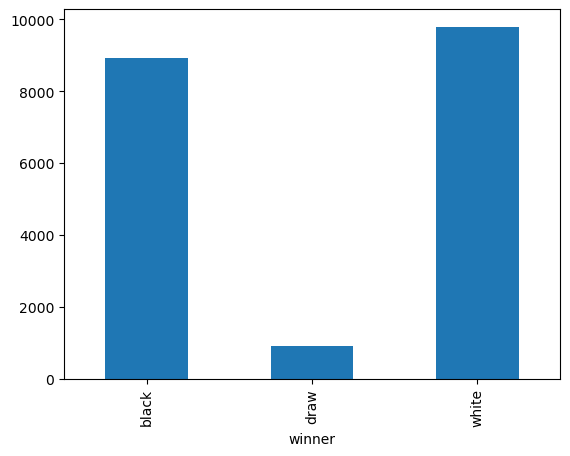

In [9]:
# This code creates a new column called 'winner_binary' which saves the winner as 0 if black won and 1 if white won.
# This code creates a new column called 'winner_binary' which saves the winner as 0 if black won and 1 if white won.
import matplotlib.pyplot as plt
import scipy.stats as stats

games_df.groupby('winner')['winner'].count().plot(kind='bar')
t_stat, p_val = stats.ttest_1samp(games_df['winner_binary'], 0.5)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_val}")

There is no effect of the color in the likelihood of winning the game. This is due to the high p-value suggesting that the Null Hypothesis is true.



Null Hypothesis: The time the game is played does not differ depending whether the most common opening move is used.

Alternative Hypothesis: The time the game is played does differentiate when the most common opening move is used.

Z-test

Treat full dataset as general game population to test for potential difference in means between the time it takes a regular game and game with specific opening move

In [ ]:
# Z-test
from scipy import stats
import numpy as np


# Treat full dataset as general game population to test for potential difference in means between the time it takes a regular game and game with specific opening move

pop_mean = games_df_time['Time_Difference'].mean()
pop_std = games_df_time['Time_Difference'].std()

opening_mode = games_df_time['opening_name'].mode().iloc[0]
sample_games = games_df_time[games_df_time['opening_name'] == opening_mode]
sample_time = sample_games['Time_Difference']

def one_sample_z_test(sample_data, population_mean, population_stddev):
    z_score = (np.mean(sample_data) - population_mean) / (population_stddev / np.sqrt(len(sample_data)))
    p_value = stats.norm.cdf(z_score)
    return p_value

print("P value: ", one_sample_z_test(sample_time, pop_mean, pop_std))

P value:  0.1519480909567062


The P-Value is higher than 0.05, so we fail to reject the Null Hypothesis and conclude that the most common opening move does not affect the time duration of the game.

**Two Sample T-Test**

Null Hypothesis: The rating has no effect on the time the game takes.

Alternative Hypothesis: The rating has an effect on the time that the game takes.

In [ ]:
# T-test
from scipy.stats import ttest_ind

rated_false = games_df_time[games_df_time['rated'] == False]['Time_Difference']
rated_true = games_df_time[games_df_time['rated'] == True]['Time_Difference']

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(rated_false, rated_true, equal_var=False)

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 2.1312156261905786
P-value: 0.03317890956675674


Since the p-value is less than our significance level, 0.02935 < 0.05, we accept the alternative hypothesis that the rating does have an effect on the time that the game takes.